Explore How to Sample

In [3]:
#!huggingface-cli login

For 2 models, generate KLL difference

In [54]:
import torch
from transformers import pipeline

model_id1 = "meta-llama/Llama-3.2-1B"
model_id2 = "gpt2" #takes forever

# pipe1 = pipeline( 
#     model=model_id1, 
#     torch_dtype=torch.bfloat16, 
# )
# pipe2 = pipeline(
#     model=model_id2, 
#     torch_dtype=torch.bfloat16)

# output = pipe1("The key to life is")
# output

In [55]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model1 = AutoModelForCausalLM.from_pretrained(model_id1, device_map="auto")
tokenizer1 = AutoTokenizer.from_pretrained(model_id1)
model2 = AutoModelForCausalLM.from_pretrained(model_id2, device_map="auto")
tokenizer2 = AutoTokenizer.from_pretrained(model_id2)

Some parameters are on the meta device because they were offloaded to the disk.


In [56]:
inputs1 = tokenizer1("The key to life is", return_tensors='pt').to("mps")
inputs2 = tokenizer2("The key to life is", return_tensors='pt').to("mps")
output1 = model1.generate(**inputs1, max_new_tokens=4, output_scores = True, output_logits = True, return_dict_in_generate=True)
output2 = model2.generate(**inputs2, max_new_tokens=4, output_scores = True, output_logits = True, return_dict_in_generate=True)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
#Ref: https://huggingface.co/docs/transformers/main/en/main_classes/text_generation#transformers.GenerationMixin.compute_transition_scores 
import numpy as np 
input_length = 1 if model1.config.is_encoder_decoder else inputs.input_ids.shape[1]
generated_tokens1 = output1.sequences[:,input_length:]
transition_scores1 = model1.compute_transition_scores(output1.sequences, output1.scores, normalize_logits=True)

for tok, score in zip(generated_tokens1[0], transition_scores1[0]):
        # | token | token string | logits | probability
        print(f"| {tok:5d} | {tokenizer1.decode(tok):8s} | {score.numpy(force=True):.4f} | {np.exp(score.numpy(force=True)):.2%}")

|   539 |  not     | -2.0936 | 12.32%
|   311 |  to      | -0.0730 | 92.96%
|  6056 |  seek    | -3.9746 | 1.88%
|   369 |  for     | -2.2337 | 10.71%


In [52]:
transition_scores12 = model2.compute_transition_scores(output1.sequences, output1.scores, normalize_logits=True)


RuntimeError: shape '[-1, 50257, 4]' is invalid for input of size 513024

In [ ]:
from pprint import pprint
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


def to_tokens_and_logprobs(model, tokenizer, input_texts):
    input_ids = tokenizer(input_texts, padding=True, return_tensors="pt").input_ids
    outputs = model(input_ids)
    probs = torch.log_softmax(outputs.logits, dim=-1).detach()

    # collect the probability of the generated token -- probability at index 0 corresponds to the token at index 1
    probs = probs[:, :-1, :]
    input_ids = input_ids[:, 1:]
    gen_probs = torch.gather(probs, 2, input_ids[:, :, None]).squeeze(-1)

    batch = []
    for input_sentence, input_probs in zip(input_ids, gen_probs):
        text_sequence = []
        for token, p in zip(input_sentence, input_probs):
            if token not in tokenizer.all_special_ids:
                text_sequence.append((tokenizer.decode(token), p.item()))
        batch.append(text_sequence)
    return batch


tokenizer = AutoTokenizer.from_pretrained("gpt2", padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("gpt2")
model.config.pad_token_id = model.config.eos_token_id

input_texts = ["One plus one is two", "Good morning", "Hello, how are you?"]

batch = to_tokens_and_logprobs(model, tokenizer, input_texts)
pprint(batch)

#### VAE Sampling

In [ ]:
from model import VAE
import torch

m1_path = "e0.pt"
m2_path = "e3.pt"
bsize = 8
n_kl_samples = 1
n_ll_samples = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m1 = torch.load(m1_path, weights_only=False, map_location=device)
m1.to(device).eval()
m2 = torch.load(m2_path, weights_only=False, map_location=device)
m2.to(device).eval()

m1_samples, m1_m1_ll = m1.sample(bsize, device)
m2_samples, m2_m2_ll = m2.sample(bsize, device)

m1_m2_ll = m1.log_likelihood(m2_samples, n_samples=n_ll_samples)
m2_m1_ll = m2.log_likelihood(m1_samples, n_samples=n_ll_samples)
kl_diff = -(m1_m1_ll + m1_m2_ll) + (m2_m1_ll + m2_m2_ll)


tensor(38.8637)

In [61]:
from tqdm import tqdm
from torchvision.utils import save_image
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, AutoModel, ViTImageProcessor

import torch
from model import VAE
import os


def get_embeddings(model, extractor, imgs, device):
    inputs = extractor(
        images=[x.detach().cpu().numpy() for x in imgs], return_tensors="pt"
    ).to(device)
    embeds = model(**inputs).last_hidden_state[:, 0].cpu()
    return embeds

def gen_kl_diff(
    m1_path: str=None,
    m2_path: str=None,
    bsize: int=100,
    n_kl_samples: int=1000,
    n_ll_samples: int=100,
    embed: bool=True,
    embed_model_name: str="google/vit-base-patch16-224",
):
    with torch.no_grad():
        if embed:
            extractor = ViTImageProcessor.from_pretrained(embed_model_name, do_rescale=False)
            embed_model = AutoModel.from_pretrained(embed_model_name, output_hidden_states=True)
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        m1 = torch.load(m1_path, weights_only=False, map_location=torch.device('cpu'))
        m1.to(device).eval()

        m2 = torch.load(
            os.path.join(m2_path),
            weights_only=False, 
            map_location=torch.device('cpu')
        )
        m2.to(device).eval()

        # File Structure
        m1_name = os.path.basename(m1_path)[:-6]
        m2_name = os.path.basename(m2_path)[:-6]

        save_dir = 'kl_diffs/' + m1_name + '_vs_' + m2_name
        Path(save_dir).mkdir(parents=True, exist_ok=True)

        
        kl_diffs = []
        m1_full_samples = []
        m2_full_samples = []

        nbatches = n_kl_samples // bsize

        for i in tqdm(range(nbatches), total=nbatches):

            m1_samples, m1_m1_ll = m1.sample(bsize, device)
            m2_samples, m2_m2_ll = m2.sample(bsize, device)

            m1_m2_ll = m1.log_likelihood(m2_samples, n_samples=n_ll_samples)
            m2_m1_ll = m2.log_likelihood(m1_samples, n_samples=n_ll_samples)

            kl_diffs.append(-(m1_m1_ll + m1_m2_ll) + (m2_m1_ll + m2_m2_ll))

            if embed:
                m1_full_samples.append(get_embeddings(embed_model, extractor, m1_samples, device))
                m2_full_samples.append(get_embeddings(embed_model, extractor, m2_samples, device))
            else:
                m1_full_samples.append(m1_samples)
                m2_full_samples.append(m2_samples)

        kl_diffs = torch.concatenate(kl_diffs)
        m1_samples = torch.concatenate(m1_full_samples)
        m2_samples = torch.concatenate(m2_full_samples)
        samples = torch.concatenate((m1_samples, m2_samples), axis=-1)
        torch.save(kl_diffs, save_dir + '/diff.pt')
        torch.save(samples, save_dir + '/img.pt')

gen_kl_diff(m1_path="trained_vaes/ld4_e9.pt", m2_path="trained_vaes/ld2_e9.pt", embed=True, embed_model_name="google/vit-base-patch16-224")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 10/10 [1:35:29<00:00, 573.00s/it]  


<Axes: ylabel='Density'>

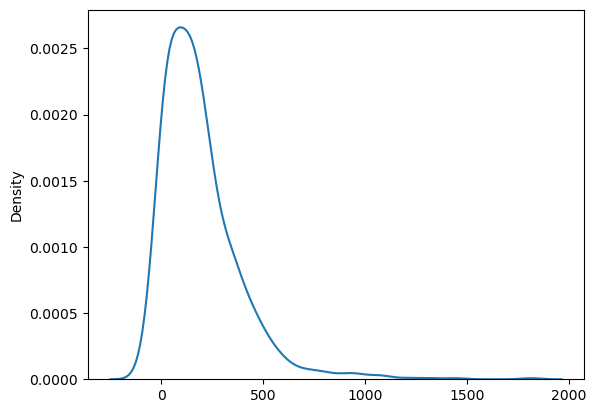

In [ ]:
# a = torch.load(os.path.join("kl_diffs/ld2_vs_ld4/diff.pt"), weights_only=True)
# sns.kdeplot(a)

In [46]:
m1_path = "trained_vaes/ld2_e9.pt"
m2_path = "trained_vaes/ld4_e9.pt"

m1_name = os.path.basename(m1_path)[:-6]
m2_name = os.path.basename(m2_path)[:-6]

save_dir = 'kl_diffs/' + m1_name + '_vs_' + m2_name
save_path = os.path.join(save_dir, m1_name + '_vs_' + m2_name)[:-3]
        
# Path(save_dir).mkdir(parents=True, exist_ok=True)
m1_name, m2_name, save_dir, save_path

('ld2', 'ld4', 'kl_diffs/ld2_vs_ld4', 'kl_diffs/ld2_vs_ld4/ld2_vs_')

In [ ]:
from meta_model import MetaDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

trainset = MetaDataset(data_dir="kl_diffs/ld2_vs_ld4")
trainloader = DataLoader(trainset, batch_size=10, shuffle=False)
for i, (imgs, labels) in tqdm(enumerate(trainloader), total=len(trainloader)):
    print(imgs.shape, labels.shape)
    print(labels)
    break

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 1536]) torch.Size([10])
tensor([ 0.2753,  0.3379,  0.0918, -0.0100,  0.4732,  0.0571,  0.0634,  0.4629,
         0.1098,  0.0793])


In [38]:
len(trainset)

10

In [1]:
class MetaDataset(Dataset):
    def __init__(self, data_dir):
        self.data = []
        self.labels = []
        self.names = []
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        for f in os.listdir(data_dir):
            if 'diff.pt' not in f:
                continue

            self.labels.append(torch.load(os.path.join(data_dir, f), weights_only=True).to(device))
            self.data.append(torch.load(os.path.join(data_dir, f[:-7] + 'img.pt'), weights_only=True).to(device))
            self.names.append(f[:-8])

        self.n_per_set = len(self.data[0])

    def __getitem__(self, idx):
        ridx = idx % self.n_per_set
        sidx = idx // self.n_per_set

        return self.data[sidx][ridx], self.labels[sidx][ridx].float() / 1000.

    def __len__(self):
        return sum([len(d) for d in self.data])


NameError: name 'Dataset' is not defined

In [33]:
import random
from torch.utils.data import Dataset
import os 
import torch

class SplitDataset(Dataset):
    def __init__(self, data_files, test_ratio=0.2, seed=42):
        self.data = []
        self.labels = []
        self.names = []
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        random.seed(seed)
        random.shuffle(data_files)
        
        split_idx = int(len(data_files) * (1 - test_ratio))
        train_files = data_files[:split_idx]
        test_files = data_files[split_idx:]

        self.train_data, self.train_labels = self.load_data(train_files, device)
        self.test_data, self.test_labels = self.load_data(test_files, device)

    def load_data(files, device):
        data = []
        labels = []
    
        for l in files:
            print(l)
            lab = "kl_diffs_all/" +l + "/diff.pt"
            da =  "kl_diffs_all/" + l + "/img.pt"
            labels.append(torch.load(lab, weights_only=True, map_location=torch.device("cpu")).to(device))
            data.append(torch.load(da, weights_only=True, map_location=torch.device("cpu")).to(device))
        return data, labels

    def get_train_set(self):
        return self.train_data, self.train_labels

    def get_test_set(self):
        return self.test_data, self.test_labels

# Example usage:
data_files = [os.path.join("kl_diffs/ld2_vs_ld4", f) for f in os.listdir("kl_diffs/ld2_vs_ld4") if 'diff.pt' in f]
split_dataset = SplitDataset(data_files)
train_data, train_labels = split_dataset.get_train_set()
test_data, test_labels = split_dataset.get_test_set()


TypeError: SplitDataset.load_data() takes 2 positional arguments but 3 were given

In [ ]:
import torch

# Example tensors
tensor1 = torch.randn(1000, 1536)
tensor2 = torch.randn(1000, 1536)
tensor3 = torch.randn(1000, 1536)

# Combine tensors along the first dimension
combined_tensor = torch.cat((tensor1, tensor2, tensor3), dim=0)
print(combined_tensor.shape)  # Output: torch.Size([3000, 1536])

In [53]:
def load_data(files, device):
    data = []
    labels = []
  
    for l in files:
        print(l)
        lab = "kl_diffs_all/" +l + "/diff.pt"
        da =  "kl_diffs_all/" + l + "/img.pt"

        a = torch.load(lab, weights_only=True, map_location=torch.device("cpu")).to(device)
        b = torch.load(da, weights_only=True, map_location=torch.device("cpu")).to(device)
 
        labels.append(a)
        data.append(b)

    return torch.cat(data, dim=0), torch.cat(labels, dim=0)

images, labels = load_data(files = os.listdir("kl_diffs_all"), device ='cpu')


ld32_vs_ld16
ld128_vs_ld16
ld32_vs_ld128
ld8_vs_ld32
ld16_vs_ld32
ld64_vs_ld8
ld64_vs_ld32
ld32_vs_ld4
ld16_vs_ld4
ld32_vs_ld2
ld16_vs_ld2
ld4_vs_ld8
ld2_vs_ld16
ld16_vs_ld128
ld128_vs_ld8
ld2_vs_ld32
ld128_vs_ld32
ld2_vs_ld8
ld4_vs_ld64
ld64_vs_ld16
ld8_vs_ld16
ld64_vs_ld4
ld8_vs_ld64
ld16_vs_ld64
ld64_vs_ld128
ld64_vs_ld2
ld4_vs_ld16
ld8_vs_ld4
ld4_vs_ld128
ld8_vs_ld2
ld4_vs_ld2
ld16_vs_ld8
ld32_vs_ld8
ld2_vs_ld64
ld2_vs_ld128
ld128_vs_ld4
ld8_vs_ld128
ld128_vs_ld2
ld32_vs_ld64
ld128_vs_ld64
ld4_vs_ld32
ld2_vs_ld4


In [56]:
images.shape, labels.shape

(torch.Size([42000, 1536]), torch.Size([42000]))

In [65]:
def split(images, labels, split_ratio=0.8):
    # Calculate the number of samples to select
    num_samples = int(labels.size(0) * split_ratio)

    # Randomly select samples for the first split
    indices = torch.randperm(labels.size(0))
    selected_images = images[indices[:num_samples]]
    selected_labels = labels[indices[:num_samples]]

    remaining_images = images[indices[num_samples:]]
    remaining_labels = labels[indices[num_samples:]]

    return (selected_images, selected_labels), (remaining_images, remaining_labels)

train, test = split(images, labels)